In [1]:
#%pip install -U -q "google-generativeai>=0.8.3"
import typing_extensions as typing
import google.generativeai as genai
from IPython.display import HTML, Markdown, display
genai.configure(api_key='')


In [2]:
from typing_extensions import TypedDict, List
import json
import time
from tqdm import tqdm
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
class ThreatParser(TypedDict):
    date: str
    description: str
    country_of_origin: List[str]
    country_of_target: List[str]
    energy_related: bool

model = genai.GenerativeModel(
    'gemini-1.5-flash-latest',
    generation_config=genai.GenerationConfig(
        temperature=0.1,
        response_mime_type="application/json",
        response_schema=ThreatParser,
    ))

input_filepath = "datasets/CSIS.json"
output_filepath = "CSIS_output.json"

def parse_threat_data(input_filepath, output_filepath):
    try:
        with open(input_filepath, 'r') as f:
            data = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError) as e:
        print(f"Error reading or parsing input JSON: {e}")
        return

    # Load existing results if file exists
    try:
        with open(output_filepath, 'r') as f:
            parsed_data = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        parsed_data = []

    processed_descriptions = {item["description"] for item in parsed_data}

    with open(output_filepath, 'w') as f:
        for index, item in enumerate(tqdm(data, desc="Processing threats")):
            if item["description"] in processed_descriptions:
                continue  # Skip already processed items
            
            response = model.generate_content(item["description"])
            time.sleep(7)  # Adding a delay to avoid rapid API calls
            try:
                parsed_item = json.loads(response.text)
                parsed_item["date"] = item["date"]
                parsed_item["description"] = item["description"]
                print(parsed_item)
            except json.JSONDecodeError as e:
                print(f"Error parsing Gemini API response: {e}, Description: {item['description']}")
                parsed_item = {"date": item["date"], "description": item["description"], "error": "Gemini API parsing failed"}
            
            parsed_data.append(parsed_item)
            
            # Save intermediate results in a valid JSON array format
            f.seek(0)
            json.dump(parsed_data, f, indent=4)
            f.truncate()

    print(f"Parsed data written to {output_filepath}")

#parse_threat_data(input_filepath, output_filepath)

In [4]:
# import json
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# output_filepath = "datasets/CSIS_output.json"

# # Standardized country names mapping
# country_aliases = {
#     "United States": "USA",
#     "U.S.": "USA",
#     "US": "USA",
#     "U.S.A.": "USA",
#     "America": "USA",
#     "United Kingdom": "UK",
#     "Great Britain": "UK",
# }

# # Load the processed JSON data
# def load_parsed_data(filepath):
#     try:
#         with open(filepath, 'r') as f:
#             return json.load(f)
#     except (FileNotFoundError, json.JSONDecodeError) as e:
#         print(f"Error loading parsed JSON: {e}")
#         return []

# data = load_parsed_data(output_filepath)

# # Ensure missing energy_related values are treated as False
# for item in data:
#     if "energy_related" not in item:
#         item["energy_related"] = False
#     if "country_of_origin" not in item:
#         item["country_of_origin"] = []
#     if "country_of_target" not in item:
#         item["country_of_target"] = []

# # Function to standardize country names
# def standardize_country_name(country):
#     return country_aliases.get(country, country)

# # Function to analyze geopolitical alignments
# def analyze_geopolitical_alignments(data):
#     alliances = {
#         "NATO": ["USA", "UK", "Germany", "France", "Canada", "Poland"],
#         "BRICS": ["China", "Russia", "India", "Brazil", "South Africa"],
#     }
    
#     df = pd.DataFrame(data)
#     df["energy_related"] = df["energy_related"].astype(bool)
#     df["country_of_origin"] = df["country_of_origin"].apply(lambda x: x if isinstance(x, list) else []).explode().dropna().reset_index(drop=True).apply(standardize_country_name)
#     df["alliance"] = df["country_of_origin"].apply(lambda x: next((a for a, members in alliances.items() if x in members), "Other"))
    
#     plt.figure(figsize=(10, 5))
#     sns.countplot(data=df, x="alliance", hue="energy_related", order=df["alliance"].value_counts().index)
#     plt.title("Threats by Geopolitical Alliances")
#     plt.show()

# # Function to analyze energy-exporting countries
# def analyze_energy_export_dependence(data):
#     energy_exporters = ["Russia", "Saudi Arabia", "Iran", "Venezuela", "USA", "Canada"]
    
#     df = pd.DataFrame(data)
#     df["energy_related"] = df["energy_related"].astype(bool)
#     df["country_of_origin"] = df["country_of_origin"].apply(lambda x: x if isinstance(x, list) else []).explode().dropna().reset_index(drop=True).apply(standardize_country_name)
#     df["energy_exporter"] = df["country_of_origin"].apply(lambda x: x in energy_exporters)
    
#     plt.figure(figsize=(10, 5))
#     sns.countplot(data=df, x="energy_exporter", hue="energy_related", order=df["energy_exporter"].value_counts().index)
#     plt.title("Energy-Exporting Nations and Threat Origination")
#     plt.xticks([0, 1], ["Non-Exporter", "Exporter"])
#     plt.show()

# # Function to analyze threat origins and targets for energy vs. general threats
# def analyze_threat_origins_targets(data):
#     df = pd.DataFrame(data)
#     df["energy_related"] = df["energy_related"].astype(bool)
#     df["country_of_origin"] = df["country_of_origin"].apply(lambda x: x if isinstance(x, list) else []).explode().dropna().reset_index(drop=True).apply(standardize_country_name)
#     df["country_of_target"] = df["country_of_target"].apply(lambda x: x if isinstance(x, list) else []).explode().dropna().reset_index(drop=True).apply(standardize_country_name)
    
#     # Aggregate counts for energy vs. non-energy threats
#     origin_counts = df.groupby(["country_of_origin", "energy_related"]).size().reset_index(name="count")
#     origin_counts = origin_counts.sort_values(by="count", ascending=False).groupby("energy_related").head(10)
#     plt.figure(figsize=(12, 6))
#     sns.barplot(data=origin_counts, x="country_of_origin", y="count", hue="energy_related", order=origin_counts["country_of_origin"].unique())
#     plt.title("Top 10 Threat Origins (Energy vs. General)")
#     plt.xticks(rotation=45)
#     plt.ylabel("Count")
#     plt.show()
    
#     # Aggregate counts for targets
#     target_counts = df.groupby(["country_of_target", "energy_related"]).size().reset_index(name="count")
#     target_counts = target_counts.sort_values(by="count", ascending=False).groupby("energy_related").head(10)
#     plt.figure(figsize=(12, 6))
#     sns.barplot(data=target_counts, x="country_of_target", y="count", hue="energy_related", order=target_counts["country_of_target"].unique())
#     plt.title("Top 10 Threat Targets (Energy vs. General)")
#     plt.xticks(rotation=45)
#     plt.ylabel("Count")
#     plt.show()

# # Function to analyze threats in ongoing conflicts
# def analyze_conflict_related_threats(data):
#     conflict_regions = {
#         "Russia-Ukraine": ["Russia", "Ukraine"],
#         "Israel-Palestine": ["Israel", "Palestine"],
#         "China-Taiwan": ["China", "Taiwan"]
#     }
    
#     df = pd.DataFrame(data)
#     df["country_of_origin"] = df["country_of_origin"].apply(lambda x: x if isinstance(x, list) else []).explode().dropna().reset_index(drop=True).apply(standardize_country_name)
#     df["conflict"] = df["country_of_origin"].apply(lambda x: next((conflict for conflict, countries in conflict_regions.items() if x in countries), None))
    
#     df = df.dropna(subset=["conflict"])  # Remove 'Other' category
    
#     plt.figure(figsize=(10, 5))
#     sns.countplot(data=df, x="conflict", hue="energy_related", order=df["conflict"].value_counts().index)
#     plt.title("Threats Related to Ongoing Conflicts")
#     plt.show()

# # Run analysis
# analyze_geopolitical_alignments(data)
# analyze_energy_export_dependence(data)
# analyze_threat_origins_targets(data)
# analyze_conflict_related_threats(data)


/scratch/slurm_tmpdir/job_1504027/ipykernel_765228/2330063032.py:103: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date"] = pd.to_datetime(df["date"], errors='coerce')
/scratch/slurm_tmpdir/job_1504027/ipykernel_765228/2330063032.py:140: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date"] = pd.to_datetime(df["date"], errors='coerce')



Energy-Related Cyber Incidents in Current Conflicts:
- Date: 2015-12-01, Conflict: Russia-Ukraine, Initiator: Russia, Target: Ukraine
- Date: 2016-12-01, Conflict: Russia-Ukraine, Initiator: Russia, Target: Ukraine
- Date: 2017-06-01, Conflict: Russia-Ukraine, Initiator: Russia, Target: Ukraine
- Date: 2018-06-01, Conflict: Russia-Ukraine, Initiator: Russia, Target: Ukraine
- Date: 2020-01-01, Conflict: Russia-Ukraine, Initiator: Russia, Target: Ukraine
- Date: 2020-05-01, Conflict: China-Taiwan, Initiator: China, Target: Taiwan
- Date: 2020-10-01, Conflict: Russia-Ukraine, Initiator: Russia, Target: Ukraine
- Date: 2022-08-01, Conflict: Russia-Ukraine, Initiator: Russia, Target: Ukraine
- Date: 2022-11-01, Conflict: Russia-Ukraine, Initiator: Russia, Target: Ukraine
- Date: 2022-12-01, Conflict: Russia-Ukraine, Initiator: Russia, Target: Ukraine
- Date: 2023-12-01, Conflict: Russia-Ukraine, Initiator: Ukraine, Target: Russia


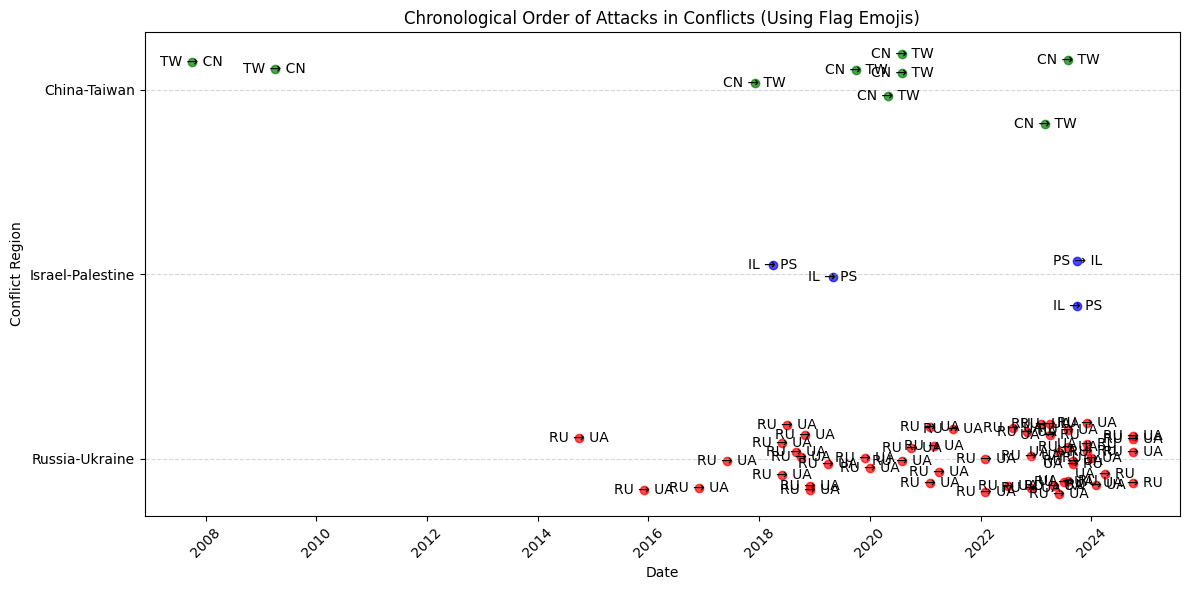

In [5]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

output_filepath = "datasets/CSIS_output.json"

# Standardized country names mapping
country_aliases = {
    "United States": "USA",
    "U.S.": "USA",
    "US": "USA",
    "U.S.A.": "USA",
    "America": "USA",
    "United Kingdom": "UK",
    "Great Britain": "UK",
}

# Country flag emojis mapping
flag_emojis = {
    "USA": "US",
    "UK": "GB",
    "Russia": "RU",
    "Ukraine": "UA",
    "Israel": "IL",
    "Palestine": "PS",
    "China": "CN",
    "Taiwan": "TW"
}

# Load the processed JSON data
def load_parsed_data(filepath):
    try:
        with open(filepath, 'r') as f:
            return json.load(f)
    except (FileNotFoundError, json.JSONDecodeError) as e:
        print(f"Error loading parsed JSON: {e}")
        return []

data = load_parsed_data(output_filepath)

# Ensure missing energy_related values are treated as False
for item in data:
    if "energy_related" not in item:
        item["energy_related"] = False
    if "country_of_origin" not in item or not isinstance(item["country_of_origin"], list):
        item["country_of_origin"] = []
    if "country_of_target" not in item or not isinstance(item["country_of_target"], list):
        item["country_of_target"] = []

# Function to standardize country names
def standardize_country_name(country):
    return country_aliases.get(country, country)

# Function to get flag emoji
def get_flag_emoji(country):
    return flag_emojis.get(country, country)


def analyze_conflict_related_threats_energy(data):
    """
    Identify and print energy-related incidents linked to current geopolitical conflicts:
    - Russia-Ukraine
    - Israel-Palestine
    - China-Taiwan
    """
    conflict_regions = {
        "Russia-Ukraine": ["Russia", "Ukraine"],
        "Israel-Palestine": ["Israel", "Palestine"],
        "China-Taiwan": ["China", "Taiwan"]
    }
    
    df = pd.DataFrame(data)

    # Ensure multiple origin and target countries are properly handled
    df = df.explode("country_of_origin").explode("country_of_target")
    
    # Standardize country names
    df["country_of_origin"] = df["country_of_origin"].apply(
        lambda x: standardize_country_name(x) if pd.notna(x) else "Unknown"
    )
    df["country_of_target"] = df["country_of_target"].apply(
        lambda x: standardize_country_name(x) if pd.notna(x) else "Unknown"
    )

    # Remove incidents where origin and target are the same (self-attacks)
    df = df[df["country_of_origin"] != df["country_of_target"]]

    # Assign conflict regions based on origin and target country combinations
    df["conflict"] = df.apply(
        lambda row: next(
            (conflict for conflict, countries in conflict_regions.items()
             if row["country_of_origin"] in countries and row["country_of_target"] in countries),
            None
        ), axis=1
    )

    # Keep only conflict-related incidents
    df = df.dropna(subset=["conflict"])

    # Ensure dates are parsed correctly
    df["date"] = pd.to_datetime(df["date"], errors='coerce')
    df = df.dropna(subset=["date"]).sort_values(by="date")

    # Filter for energy-related incidents
    df_conflict_energy = df[df["energy_related"]]

    # Print results
    print("\nEnergy-Related Cyber Incidents in Current Conflicts:")
    if df_conflict_energy.empty:
        print("No energy-related incidents found in the dataset for these conflicts.")
    else:
        for _, row in df_conflict_energy.iterrows():
            print(f"- Date: {row['date'].date()}, Conflict: {row['conflict']}, "
                  f"Initiator: {row['country_of_origin']}, Target: {row['country_of_target']}")

# Run the function
analyze_conflict_related_threats_energy(data)


# Function to analyze threats in ongoing conflicts using an improved timeline plot
def analyze_conflict_related_threats(data):
    conflict_regions = {
        "Russia-Ukraine": ["Russia", "Ukraine"],
        "Israel-Palestine": ["Israel", "Palestine"],
        "China-Taiwan": ["China", "Taiwan"]
    }
    
    df = pd.DataFrame(data)
    df = df.explode("country_of_origin").explode("country_of_target")  # Ensure multiple origins and targets are handled
    df["country_of_origin"] = df["country_of_origin"].apply(lambda x: standardize_country_name(x) if pd.notna(x) else "Unknown")
    df["country_of_target"] = df["country_of_target"].apply(lambda x: standardize_country_name(x) if pd.notna(x) else "Unknown")
    
    # Remove self-attacks (e.g., China attacking China)
    df = df[df["country_of_origin"] != df["country_of_target"]]
    
    df["conflict"] = df.apply(lambda row: next((conflict for conflict, countries in conflict_regions.items() if row["country_of_origin"] in countries and row["country_of_target"] in countries), None), axis=1)
    df = df.dropna(subset=["conflict"])  # Remove 'Other' category
    df["date"] = pd.to_datetime(df["date"], errors='coerce')
    df = df.dropna(subset=["date"]).sort_values(by="date")
    
    # Improved Timeline Plot
    plt.figure(figsize=(12, 6))  # Increased y-axis length
    colors = {"Russia-Ukraine": "red", "Israel-Palestine": "blue", "China-Taiwan": "green"}
    y_positions = {"Russia-Ukraine": 1, "Israel-Palestine": 2, "China-Taiwan": 3}
    
    for _, row in df.iterrows():
        conflict = row["conflict"]
        y_offset = y_positions[conflict] + np.random.uniform(-0.2, 0.2)  # Increased spacing to reduce overlap
        plt.scatter(row["date"], y_offset, color=colors[conflict], alpha=0.7)
        
        # Display flags and attack indicator
        flag_origin = get_flag_emoji(row["country_of_origin"])
        flag_target = get_flag_emoji(row["country_of_target"])
        plt.text(row["date"], y_offset, f"{flag_origin} → {flag_target}", fontsize=10, ha='center', va='center')
    
    plt.yticks([1, 2, 3], ["Russia-Ukraine", "Israel-Palestine", "China-Taiwan"])
    plt.xlabel("Date")
    plt.ylabel("Conflict Region")
    plt.title("Chronological Order of Attacks in Conflicts (Using Flag Emojis)")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    #plt.savefig("current_conflics_csic.pdf")
    plt.show()

# Run analysis
analyze_conflict_related_threats(data)


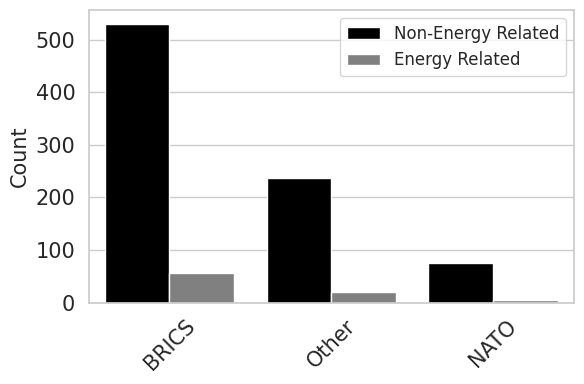

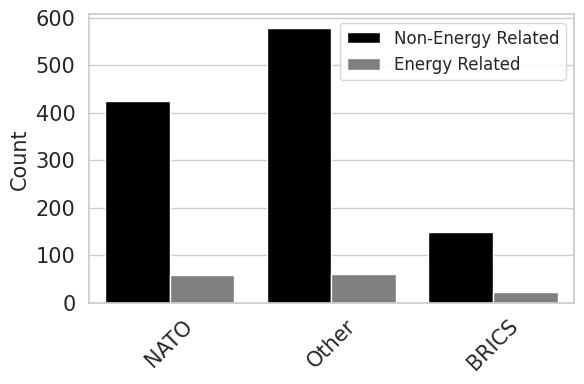

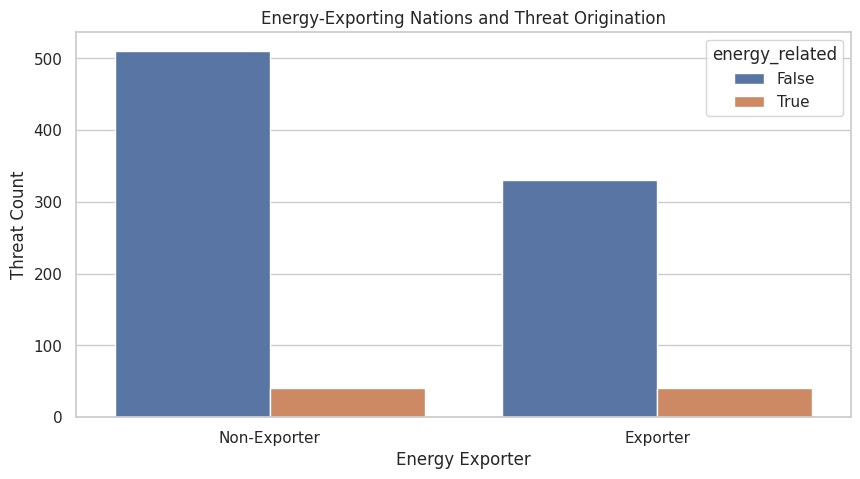

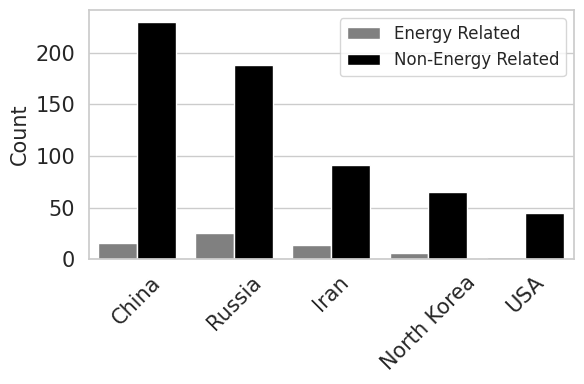

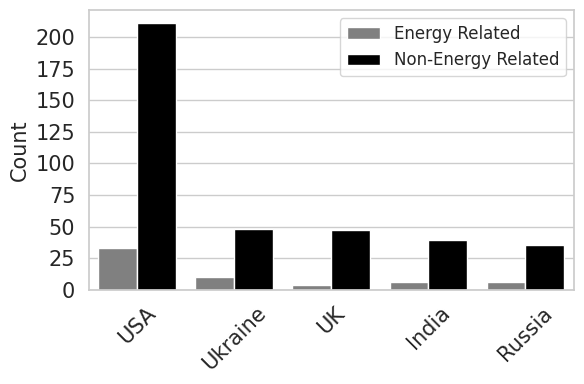

/scratch/slurm_tmpdir/job_1504027/ipykernel_765228/1153875629.py:371: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date"] = pd.to_datetime(df["date"], errors='coerce')


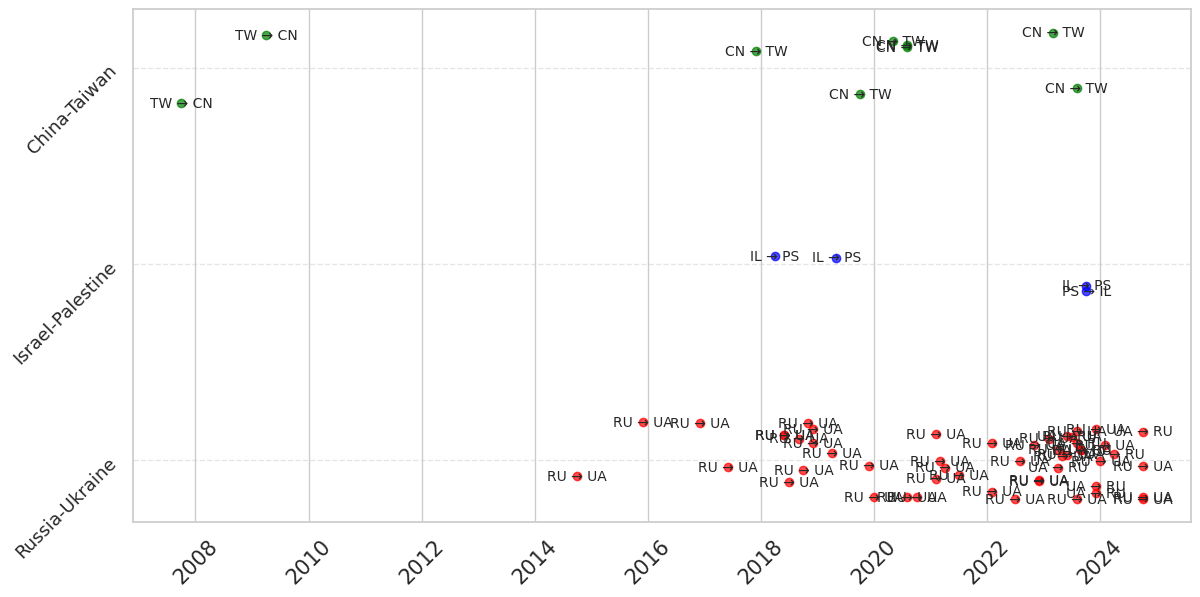

In [6]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set a seaborn style (optional)
sns.set_theme(style="whitegrid")

# Filepath to the processed JSON data
output_filepath = "datasets/CSIS_output.json"

# Standardized country names mapping
country_aliases = {
    "United States": "USA",
    "U.S.": "USA",
    "US": "USA",
    "U.S.A.": "USA",
    "America": "USA",
    "United Kingdom": "UK",
    "Great Britain": "UK",
}

# Country flag emojis mapping (or country codes used for flag lookup)
flag_emojis = {
    "USA": "US",
    "UK": "GB",
    "Russia": "RU",
    "Ukraine": "UA",
    "Israel": "IL",
    "Palestine": "PS",
    "China": "CN",
    "Taiwan": "TW"
}

# -----------------------------------------------------------------------------
# Helper functions
# -----------------------------------------------------------------------------

def load_parsed_data(filepath):
    """Load JSON data from a file. Returns an empty list on error."""
    try:
        with open(filepath, 'r') as f:
            return json.load(f)
    except (FileNotFoundError, json.JSONDecodeError) as e:
        print(f"Error loading parsed JSON: {e}")
        return []


def standardize_country_name(country):
    """Standardize country names using the country_aliases mapping."""
    return country_aliases.get(country, country)


def get_flag_emoji(country):
    """Return a flag emoji (or country code) based on the country name."""
    return flag_emojis.get(country, country)


def ensure_list_fields(data_item):
    """Ensure the data item has valid list entries for country fields."""
    if "energy_related" not in data_item:
        data_item["energy_related"] = False
    if "country_of_origin" not in data_item or not isinstance(data_item["country_of_origin"], list):
        data_item["country_of_origin"] = []
    if "country_of_target" not in data_item or not isinstance(data_item["country_of_target"], list):
        data_item["country_of_target"] = []


# -----------------------------------------------------------------------------
# Load and pre-process the data
# -----------------------------------------------------------------------------

data = load_parsed_data(output_filepath)

# Ensure every item has the necessary fields
for item in data:
    ensure_list_fields(item)


# -----------------------------------------------------------------------------
# Analysis functions
# -----------------------------------------------------------------------------

def analyze_geopolitical_alignments(data):
    """Analyze threats by geopolitical alliances (NATO, BRICS, or Other)."""
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set_theme(style="whitegrid")

    alliances = {
        "NATO": [
            "Albania", "Belgium", "Bulgaria", "Canada", "Croatia", "Czechia", "Denmark",
            "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Iceland",
            "Italy", "Latvia", "Lithuania", "Luxembourg", "Montenegro", "Netherlands",
            "North Macedonia", "Norway", "Poland", "Portugal", "Romania", "Slovakia",
            "Slovenia", "Spain", "Sweden", "Türkiye", "UK", "USA"
        ],
        "BRICS": [
            "China", "Russia", "India", "Brazil", "South Africa", "Egypt",
            "Ethiopia", "Indonesia", "Iran", "United Arab Emirates"
        ],
    }
    
    df = pd.DataFrame(data)
    df["energy_related"] = df["energy_related"].astype(bool)
    
    # Explode country_of_origin
    df["country_of_origin"] = df["country_of_origin"].apply(lambda x: x if isinstance(x, list) else [])
    df_exploded = df.explode("country_of_origin")
    
    # Standardize names, remove empty or NaN
    df_exploded["country_of_origin"] = df_exploded["country_of_origin"].apply(
        lambda x: standardize_country_name(x) if pd.notna(x) and x != "" else None
    )
    df_exploded = df_exploded.dropna(subset=["country_of_origin"])
    
    # Determine alliance membership
    def find_alliance(country):
        for a, members in alliances.items():
            if country in members:
                return a
        return "Other"
    
    df_exploded["alliance"] = df_exploded["country_of_origin"].apply(find_alliance)
    
    # Map boolean to strings so we can match the style from your other plots
    df_exploded["energy_status"] = df_exploded["energy_related"].map({
        True: "Energy Related",
        False: "Non-Energy Related"
    })
    
    # Plot in a similar style to 'analyze_threat_origins_targets'
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(
        data=df_exploded,
        x="alliance",
        hue="energy_status",
        palette={"Energy Related": "grey", "Non-Energy Related": "black"}
    )
    
    # Remove big title, adjust legend and axes to match style
    plt.legend(title="", fontsize=12)
    plt.xlabel("", fontsize=15)
    plt.ylabel("Count", fontsize=15)
    plt.xticks(fontsize=15, rotation=45)
    plt.yticks(fontsize=15)
    
    plt.tight_layout()
    plt.savefig("alliances_origin_csis.pdf")
    plt.show()

    ###

    # ---- Threat Targets ----
    # Ensure each entry in "country_of_target" is a list.
    df["country_of_target"] = df["country_of_target"].apply(lambda x: x if isinstance(x, list) else [])
    # Explode the list so that each row corresponds to a single target country.
    df_exploded = df.explode("country_of_target")
    
    # Standardize country names and filter out empty or NaN values.
    df_exploded["country_of_target"] = df_exploded["country_of_target"].apply(
        lambda x: standardize_country_name(x) if pd.notna(x) and x != "" else None
    )
    df_exploded = df_exploded.dropna(subset=["country_of_target"])
    
    # Determine alliance membership based on the target country.
    def find_alliance(country):
        for alliance_name, members in alliances.items():
            if country in members:
                return alliance_name
        return "Other"
    
    df_exploded["alliance"] = df_exploded["country_of_target"].apply(find_alliance)
    
    # Map the boolean energy flag to a string for labeling.
    df_exploded["energy_status"] = df_exploded["energy_related"].map({
        True: "Energy Related",
        False: "Non-Energy Related"
    })
    
    # Plot in a similar style to your origins plot.
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(
        data=df_exploded,
        x="alliance",
        hue="energy_status",
        palette={"Energy Related": "grey", "Non-Energy Related": "black"}
    )
    
    # Adjust labels and legend to match the style.
    plt.legend(title="", fontsize=12)
    plt.xlabel("", fontsize=15)
    plt.ylabel("Count", fontsize=15)
    plt.xticks(fontsize=15, rotation=45)
    plt.yticks(fontsize=15)
    
    plt.tight_layout()
    plt.savefig("alliances_targets_csis.pdf")
    plt.show()


def analyze_energy_export_dependence(data):
    """Analyze threats with respect to energy-exporting countries."""
    energy_exporters = ["Russia", "Saudi Arabia", "Iran", "Venezuela", "USA", "Canada"]
    
    df = pd.DataFrame(data)
    df["energy_related"] = df["energy_related"].astype(bool)
    
    # Explode the origin column
    df["country_of_origin"] = df["country_of_origin"].apply(lambda x: x if isinstance(x, list) else [])
    df_exploded = df.explode("country_of_origin")
    
    df_exploded["country_of_origin"] = df_exploded["country_of_origin"].apply(
        lambda x: standardize_country_name(x) if pd.notna(x) else x
    )
    df_exploded = df_exploded.dropna(subset=["country_of_origin"])
    df_exploded = df_exploded[df_exploded["country_of_origin"] != ""]
    
    # Flag if the country is an energy exporter
    df_exploded["energy_exporter"] = df_exploded["country_of_origin"].apply(lambda x: x in energy_exporters)
    
    plt.figure(figsize=(10, 5))
    order = df_exploded["energy_exporter"].value_counts().index
    sns.countplot(data=df_exploded, x="energy_exporter", hue="energy_related", order=order)
    plt.title("Energy-Exporting Nations and Threat Origination")
    plt.xlabel("Energy Exporter")
    plt.ylabel("Threat Count")
    plt.xticks(ticks=[0, 1], labels=["Non-Exporter", "Exporter"])
    plt.savefig("exporters_csis.pdf")
    plt.show()


def analyze_threat_origins_targets(data):
    """Analyze threat origins and targets, showing top 5 countries (by total incident count) for each.
    For each country we aggregate the counts and show the breakdown for energy-related (True) vs. non-energy (False) detections.
    """
    # Convert data to DataFrame.
    df = pd.DataFrame(data)
    df["energy_related"] = df["energy_related"].astype(bool)
    
    #### Process Origins ####
    df_origin = df.copy()
    df_origin["country_of_origin"] = df_origin["country_of_origin"].apply(lambda x: x if isinstance(x, list) else [])
    df_origin = df_origin.explode("country_of_origin")
    df_origin["country_of_origin"] = df_origin["country_of_origin"].apply(lambda x: standardize_country_name(x) if pd.notna(x) else x)
    df_origin = df_origin.dropna(subset=["country_of_origin"])
    df_origin = df_origin[df_origin["country_of_origin"] != ""]
    
    # Aggregate by country: count incidents and also count energy-related separately.
    origin_agg = df_origin.groupby("country_of_origin").agg(
        total=("country_of_origin", "count"),
        energy_true=("energy_related", lambda x: (x==True).sum()),
        energy_false=("energy_related", lambda x: (x==False).sum())
    ).reset_index()
    
    # Get top 5 countries by total incident count.
    top5_origin = origin_agg.sort_values("total", ascending=False).head(5)
    
    # Melt for plotting.
    top5_origin_melt = top5_origin.melt(id_vars=["country_of_origin", "total"], 
                                         value_vars=["energy_true", "energy_false"],
                                         var_name="energy_status", value_name="count")
    top5_origin_melt["energy_status"] = top5_origin_melt["energy_status"].map({
        "energy_true": "Energy Related",
        "energy_false": "Non-Energy Related"
    })
    
    # Plot origins.
    plt.figure(figsize=(6, 4))
    ax1 = sns.barplot(data=top5_origin_melt, x="country_of_origin", y="count",
                      hue="energy_status", palette={"Energy Related": "grey", "Non-Energy Related": "black"})
    #plt.title("Top 5 Threat Origins by Count", fontsize=16)
    plt.xlabel("", fontsize=15)
    plt.ylabel("Count", fontsize=15)
    plt.xticks(fontsize=15, rotation=45)
    plt.yticks(fontsize=15)
    plt.legend(title="", fontsize=12, title_fontsize=14)
    plt.tight_layout()
    plt.savefig("origins_csis.pdf")
    plt.show()
    
    #### Process Targets ####
    df_target = df.copy()
    df_target["country_of_target"] = df_target["country_of_target"].apply(lambda x: x if isinstance(x, list) else [])
    df_target = df_target.explode("country_of_target")
    df_target["country_of_target"] = df_target["country_of_target"].apply(lambda x: standardize_country_name(x) if pd.notna(x) else x)
    df_target = df_target.dropna(subset=["country_of_target"])
    df_target = df_target[df_target["country_of_target"] != ""]
    
    # Aggregate by country for targets.
    target_agg = df_target.groupby("country_of_target").agg(
        total=("country_of_target", "count"),
        energy_true=("energy_related", lambda x: (x==True).sum()),
        energy_false=("energy_related", lambda x: (x==False).sum())
    ).reset_index()
    
    # Get top 5 targets by total incident count.
    top5_target = target_agg.sort_values("total", ascending=False).head(5)
    
    # Melt for plotting.
    top5_target_melt = top5_target.melt(id_vars=["country_of_target", "total"],
                                         value_vars=["energy_true", "energy_false"],
                                         var_name="energy_status", value_name="count")
    top5_target_melt["energy_status"] = top5_target_melt["energy_status"].map({
        "energy_true": "Energy Related",
        "energy_false": "Non-Energy Related"
    })
    
    # Plot targets.
    plt.figure(figsize=(6, 4))
    ax2 = sns.barplot(data=top5_target_melt, x="country_of_target", y="count",
                      hue="energy_status", palette={"Energy Related": "grey", "Non-Energy Related": "black"})
    #plt.title("Top 5 Threat Targets by Count", fontsize=16)
    plt.xlabel("", fontsize=15)
    plt.ylabel("Count", fontsize=15)
    plt.xticks(fontsize=15, rotation=45)
    plt.yticks(fontsize=15)
    plt.legend(title="", fontsize=12, title_fontsize=14)
    plt.tight_layout()
    plt.savefig("targets_csis.pdf")
    plt.show()
    
def analyze_conflict_related_threats(data):
    """
    Analyze threats related to ongoing conflicts using a timeline plot.
    This function looks for events where both the country of origin and target
    belong to a predefined conflict region and then plots the events chronologically.
    """
    conflict_regions = {
        "Russia-Ukraine": ["Russia", "Ukraine"],
        "Israel-Palestine": ["Israel", "Palestine"],
        "China-Taiwan": ["China", "Taiwan"]
    }
    
    df = pd.DataFrame(data)
    
    # Ensure the country fields are lists
    df["country_of_origin"] = df["country_of_origin"].apply(lambda x: x if isinstance(x, list) else [])
    df["country_of_target"] = df["country_of_target"].apply(lambda x: x if isinstance(x, list) else [])
    
    # Explode both origin and target so each row corresponds to a single pair
    df = df.explode("country_of_origin").explode("country_of_target")
    
    # Standardize the country names
    df["country_of_origin"] = df["country_of_origin"].apply(
        lambda x: standardize_country_name(x) if pd.notna(x) else x
    )
    df["country_of_target"] = df["country_of_target"].apply(
        lambda x: standardize_country_name(x) if pd.notna(x) else x
    )
    
    # Drop rows with missing country values and remove self-attacks
    df = df.dropna(subset=["country_of_origin", "country_of_target"])
    df = df[df["country_of_origin"] != df["country_of_target"]]
    
    # Determine the conflict region (if any) where both countries belong
    def get_conflict(row):
        for conflict, countries in conflict_regions.items():
            if row["country_of_origin"] in countries and row["country_of_target"] in countries:
                return conflict
        return None

    df["conflict"] = df.apply(get_conflict, axis=1)
    df = df.dropna(subset=["conflict"])
    
    # Convert date column to datetime (assumes a "date" field exists in the data)
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors='coerce')
        df = df.dropna(subset=["date"]).sort_values(by="date")
    else:
        print("No date column found for timeline analysis.")
        return
    
    plt.figure(figsize=(12, 6))
    colors = {"Russia-Ukraine": "red", "Israel-Palestine": "blue", "China-Taiwan": "green"}
    # Define fixed y-axis positions for each conflict region
    y_positions = {"Russia-Ukraine": 1, "Israel-Palestine": 2, "China-Taiwan": 3}
    
    # Plot each event with a small random vertical offset to reduce overlap
    for _, row in df.iterrows():
        conflict = row["conflict"]
        y_offset = y_positions[conflict] + np.random.uniform(-0.2, 0.2)
        plt.scatter(row["date"], y_offset, color=colors.get(conflict, "gray"), alpha=0.7)
        
        # Retrieve flag information for origin and target
        flag_origin = get_flag_emoji(row["country_of_origin"])
        flag_target = get_flag_emoji(row["country_of_target"])
        plt.text(row["date"], y_offset, f"{flag_origin} → {flag_target}", fontsize=10, ha='center', va='center')
    
    plt.yticks(list(y_positions.values()), list(y_positions.keys()))
    #plt.xlabel("Date")
    #plt.ylabel("Conflict Region")
    #plt.title("Chronological Order of Attacks in Conflicts (CSIC)")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=13)
    plt.savefig("current_conflics_csic.pdf")
    plt.show()


# -----------------------------------------------------------------------------
# Run all analyses
# -----------------------------------------------------------------------------

analyze_geopolitical_alignments(data)
analyze_energy_export_dependence(data)
analyze_threat_origins_targets(data)
analyze_conflict_related_threats(data)
